In [ ]:
# default_exp n02

# Classification with PyTorch

> Defining and training a Pytorch model for classification problems and visualizing the results dynamically.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from fastai.vision import Module
from IPython.core.debugger import set_trace

from learn_ai_today.n01 import GeneralFit

In [ ]:
iris = datasets.load_iris()
X = iris.data   # Get training attributes
y = iris.target # Get labels
input_size = X.shape[-1]
cats = np.sum(np.unique(y)).astype(int)
print('Number of samples:', X.shape[0])
print('Number of attributes:', input_size)
print('Number of categories:', cats)

Number of samples: 150
Number of attributes: 4
Number of categories: 3


/home/mnpinto/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


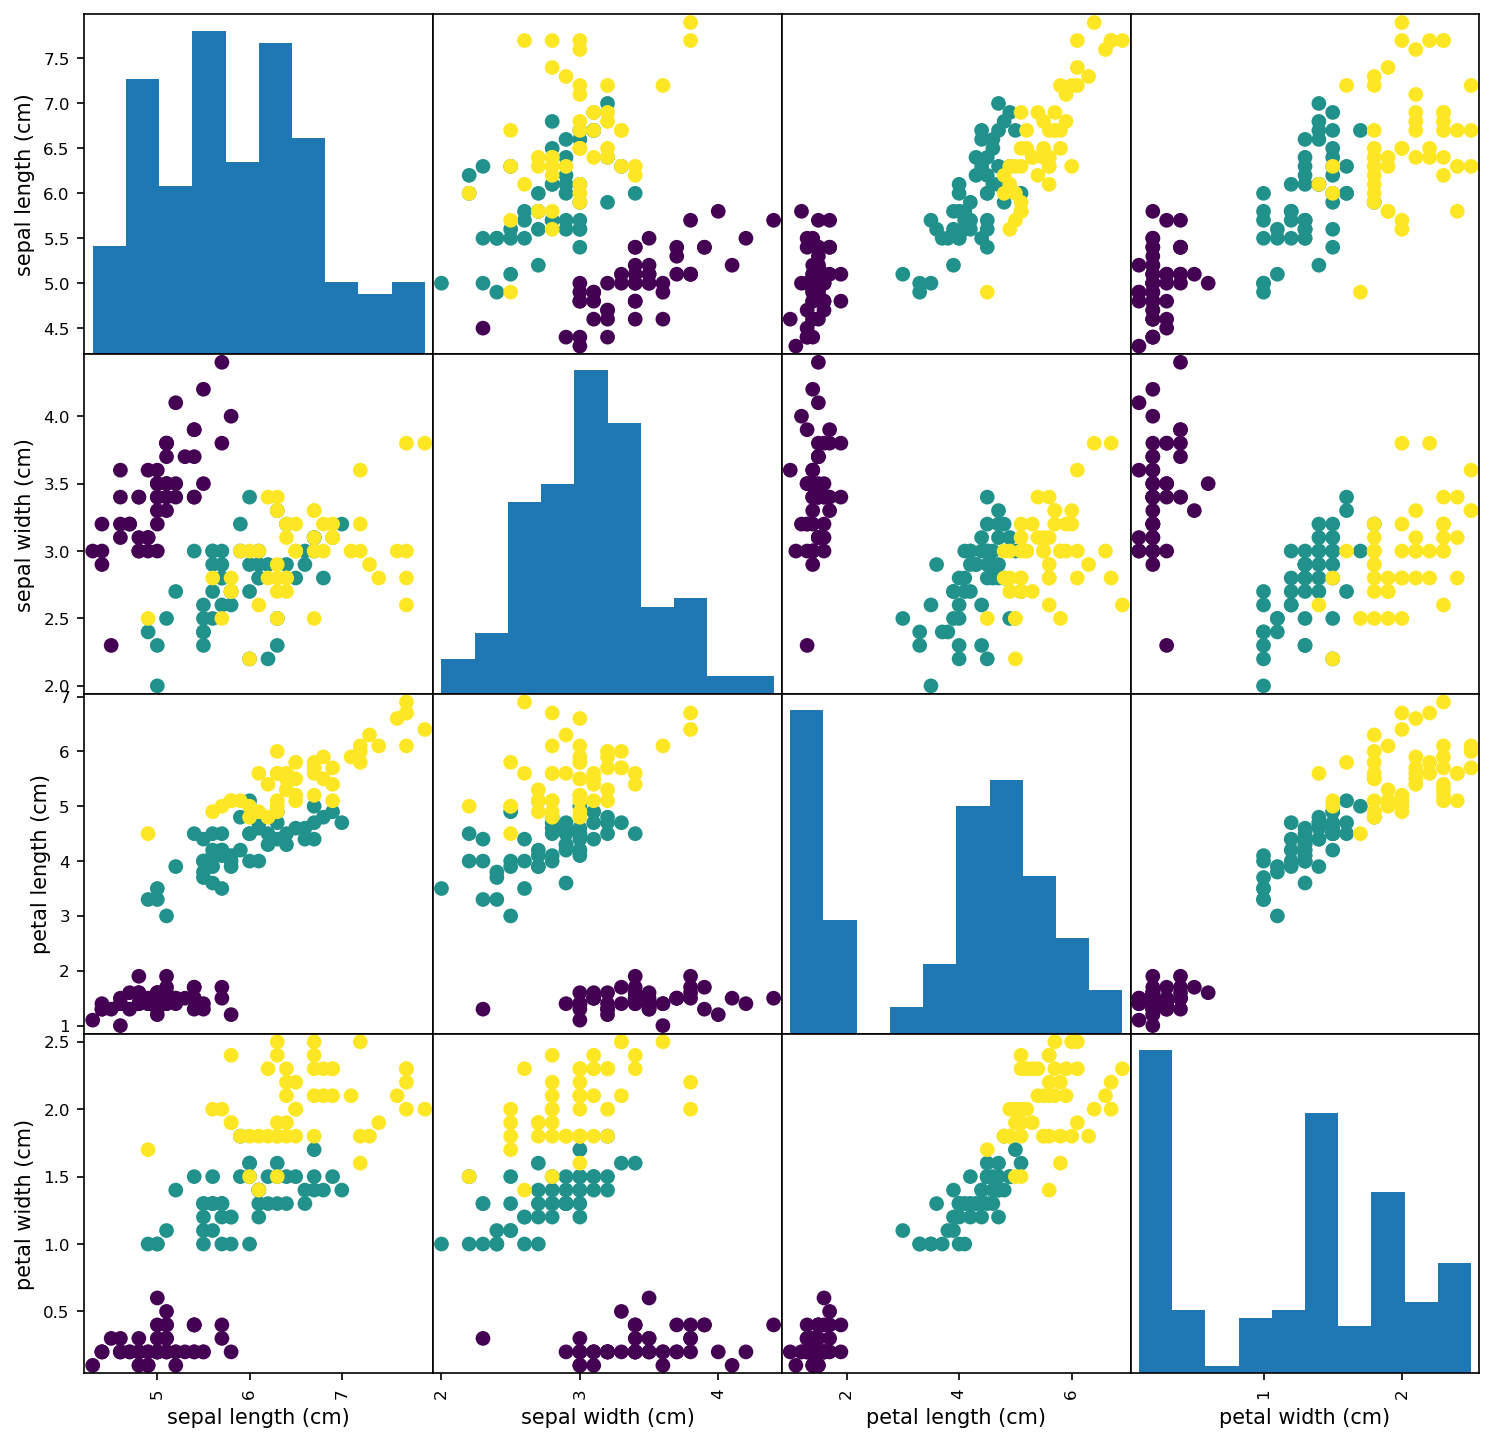

In [ ]:
df = pd.DataFrame({k:X[:,i] for i,k in enumerate(iris['feature_names'])})
fig, ax = plt.subplots(figsize=(12,12), dpi=150)
pd.plotting.scatter_matrix(df, figsize=(12,12), c=y, s=200, alpha=1, ax=ax);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=2020)

In [ ]:
model = GeneralFit(int(input_size), int(cats))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
x_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [ ]:
def accuracy_multi(x, y):
    return (x.argmax(-1) == y).float().mean()

def fit(x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs):
    loss_history      = [] # to save the loss at each epoch.
    loss_test_history = [] # to save the test loss at each epoch.
    out_history       = [] # to save the parameters at each epoch
    acc_train_history = []
    acc_test_history  = [] 
    for ii, epoch in enumerate(range(num_epochs)):
        # forward
        model.train()
        out       = model(x_train)
        loss      = criterion(out, y_train)
        acc_train = accuracy_multi(out, y_train)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # test
        model.eval()
        out_test  = model(x_test)
        loss_test = criterion(out_test, y_test)
        acc_test  = accuracy_multi(out_test, y_test)
        
        loss_history.append(loss.item())
        loss_test_history.append(loss_test.item())
        acc_train_history.append(acc_train)
        acc_test_history.append(acc_test)
        if ii == 0:
            out_history = out.detach().cpu().numpy()
        else:
            out_history = np.concatenate((out_history, out.detach().cpu().numpy()), axis=-1)
        
    print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))
    return loss_history, loss_test_history, out_history, acc_train_history, acc_test_history

In [ ]:
%time 
loss_train, loss_test, out, acc_train, acc_test = fit(
    x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs=1000)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
Epoch[1000/1000], loss:0.080536


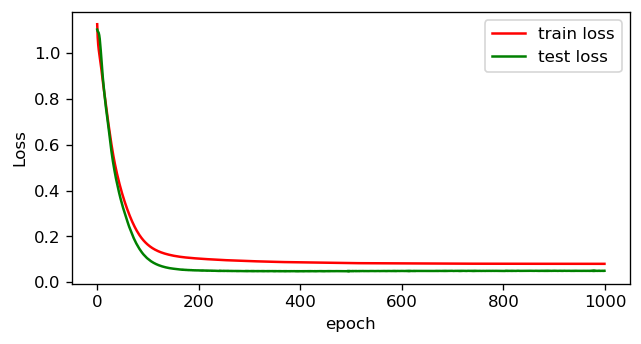

In [ ]:
plt.figure(figsize=(6,3), dpi=120)
plt.plot(loss_train, color='red', label='train loss')
plt.plot(loss_test, color='green', label='test loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

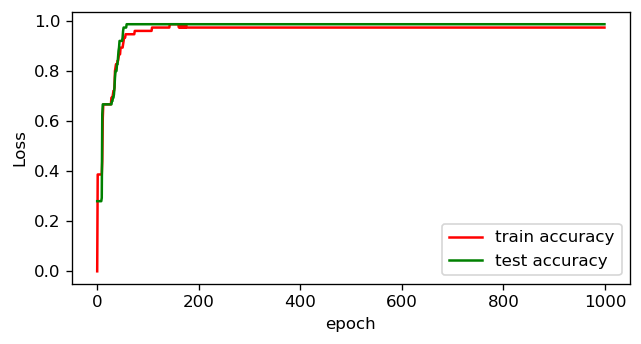

In [ ]:
plt.figure(figsize=(6,3), dpi=120)
plt.plot(acc_train, color='red', label='train accuracy')
plt.plot(acc_test, color='green', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
yep = model(x_train) # compute the y estimate
yep = yep.detach() # get the values from the variable, them pass them to the cpu and convert to a numpy array
ye = np.argmax(yep, axis=-1) 

yetp = model(x_test) # compute the y estimate
yetp = yetp.detach() # get the values from the variable, them pass them to the cpu and convert to a numpy array
yet = np.argmax(yetp, axis=-1)

In [ ]:
print('Train accuracy: ', (torch.sum(y_train == ye).float()/len(ye)).item())
print('Test accuracy: ', (torch.sum(y_test == yet).float()/len(yet)).item())

Train accuracy:  0.9733333587646484
Test accuracy:  0.9866666793823242


## Train for simple example and plot decision boundaries

In [ ]:
def accuracy_multi(x, y):
    return (x.argmax(-1) == y).float().mean()

def fit(x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs):
    loss_history      = [] # to save the loss at each epoch.
    loss_test_history = [] # to save the test loss at each epoch.
    out_history       = [] # to save the parameters at each epoch
    acc_train_history = []
    acc_test_history  = [] 
    predss = []
    for ii, epoch in enumerate(range(num_epochs)):
        # forward
        model.train()
        out       = model(x_train)
        loss      = criterion(out, y_train)
        acc_train = accuracy_multi(out, y_train)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # test
        model.eval()
        out_test  = model(x_test)
        loss_test = criterion(out_test, y_test)
        acc_test  = accuracy_multi(out_test, y_test)
        
        loss_history.append(loss.item())
        loss_test_history.append(loss_test.item())
        acc_train_history.append(acc_train)
        acc_test_history.append(acc_test)
        if ii == 0:
            out_history = out.detach().cpu().numpy()
        else:
            out_history = np.concatenate((out_history, out.detach().cpu().numpy()), axis=-1)
        
        x1 = np.linspace(0, 5, num=100)
        x2 = np.linspace(0, 5, num=100)
        x1, x2 = np.meshgrid(x1, x2)
        x1 = torch.from_numpy(x1).float()
        x2 = torch.from_numpy(x2).float()

        model.eval()
        with torch.no_grad():
            preds = model(torch.cat((x1.view(-1,1), x2.view(-1,1)), dim=-1))
            preds = preds.view(100,100,-1).argmax(-1)
        predss.append(preds)
        
    print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))
    return loss_history, loss_test_history, out_history, acc_train_history, acc_test_history, predss

In [ ]:
model = GeneralFit(2, int(cats))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
x_train = x_train[:, (1,3)]
x_test = x_test[:,(1,3)]

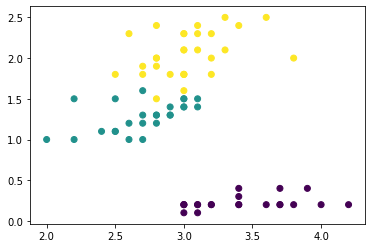

In [ ]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

In [ ]:
%time 
loss_train, loss_test, out, acc_train, acc_test, predss = fit(
    x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs=1000)

predss = np.array(torch.cat([p[None] for p in predss]).numpy())[::2]

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 4.05 µs
Epoch[1000/1000], loss:0.091078


In [ ]:
x1 = np.linspace(0, 5, num=100)
x2 = np.linspace(0, 5, num=100)
x1, x2 = np.meshgrid(x1, x2)

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
%%capture
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=120)

train_plot = ax1.pcolormesh(x1, x2, predss[0], cmap='RdYlGn_r')
ax1.scatter(x_train[:,0], x_train[:,1], c=y_train)
ax1.axis([1.9, 4.3, 0, 3])

test_plot = ax2.pcolormesh(x1, x2, predss[0], cmap='RdYlGn_r')
ax2.scatter(x_test[:,0], x_test[:,1], c=y_test)
ax2.axis([1.9, 4.3, 0, 3])

ax1.set_title('Train')
ax2.set_title('Test')

# animation function. This is called sequentially
def animate(i):
    train_plot.set_array(predss[i][:-1, :-1].ravel())
    test_plot.set_array(predss[i][:-1, :-1].ravel())
    return (train_plot, test_plot)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=len(predss), interval=30, blit=True)

In [ ]:
HTML(anim.to_html5_video())